# Gaussian Process regression Hemocell analysis

In [1]:
import numpy as np
import pandas as pd

from lxml import etree

import matplotlib.pyplot as plt

from scipy.stats import norm,truncnorm,uniform,multivariate_normal

from SALib.sample import saltelli
from SALib.analyze import sobol

from tqdm import tqdm

from sklearn.neighbors.kde import KernelDensity
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel,WhiteKernel

import statsmodels.api as sm

import UQLib.calibration.TMCMC as TMCMC

from local_config import *

np.random.seed(6345789)

In [2]:
names = {"kLink":r"$\kappa_l$","kBend":r"$\kappa_b$",
         "viscosityRatio":r"$\Lambda$","err":r"$\sigma^m$",
         "shearrate":r"$\dot{\gamma}$"}

## Load training data

In [3]:
# Load simulation data
mode="visc"

imin = 0
imax = 10

# Load simulation data
x_train = np.load("%s/train_hemocell_samples_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
y_train = np.load("%s/train_hemocell_qoi_%s_%i_%i.npy" % (outputpath,mode,imin,imax))
c_err = np.load("%s/train_hemocell_c_err_%s_%i_%i.npy" % (outputpath,mode,imin,imax))

x_fail = x_train[y_train[:,0] < 0,:-3]

# Remove failed simulation outputs
x_train = x_train[y_train[:,0] >= 0,:-3]
c_err = c_err[y_train[:,0] >= 0]
y_train = y_train[y_train[:,0] >= 0]

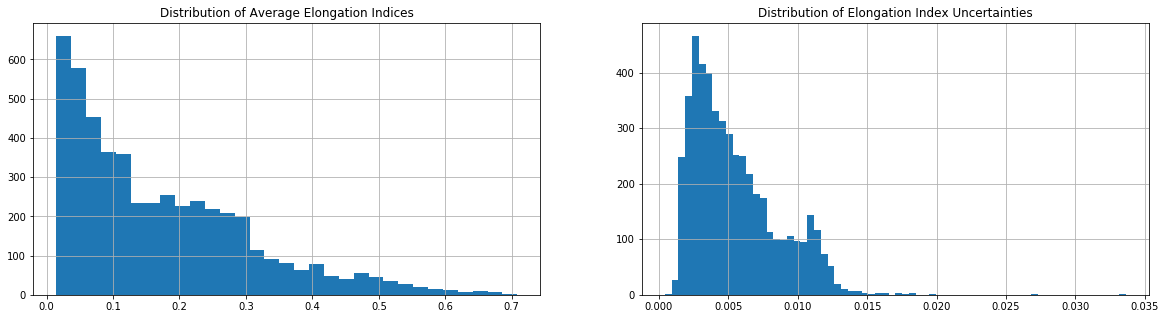

In [4]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Distribution of Average Elongation Indices")
plt.grid(True)
plt.hist(y_train,bins='auto')

plt.subplot(1,2,2)
plt.title("Distribution of Elongation Index Uncertainties")
plt.grid(True)
plt.hist(c_err,bins='auto')
plt.show()

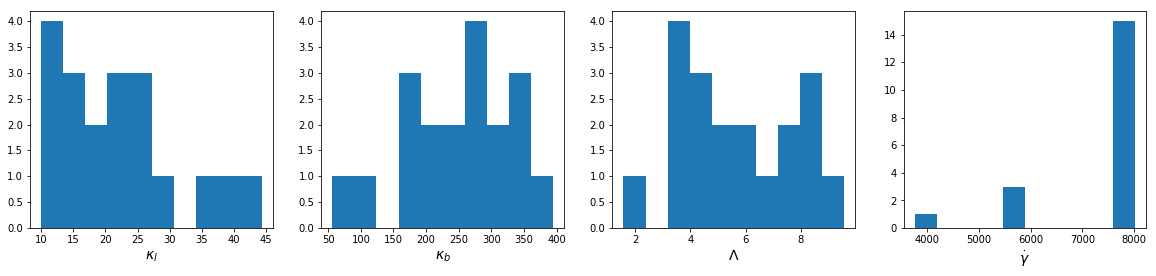

[[1.04376184e+01 3.40380112e+02 3.73208103e+00 3.76053215e+03]
 [1.39042694e+01 2.94625541e+02 7.30811798e+00 5.49002217e+03]
 [2.31973826e+01 1.63810966e+02 3.38292797e+00 5.49002217e+03]
 [2.23744680e+01 5.62990190e+01 4.83929383e+00 5.49002217e+03]
 [3.45660501e+01 2.63656543e+02 3.79682998e+00 8.01773836e+03]
 [1.83900561e+01 2.88338784e+02 6.72501492e+00 8.01773836e+03]
 [2.57752660e+01 2.97697905e+02 8.35316019e+00 8.01773836e+03]
 [1.18441405e+01 2.68337524e+02 5.17894894e+00 8.01773836e+03]
 [1.80835418e+01 3.55916214e+02 4.52639444e+00 8.01773836e+03]
 [1.39079445e+01 1.81466726e+02 1.56982462e+00 8.01773836e+03]
 [2.10134854e+01 2.50621915e+02 6.10036263e+00 8.01773836e+03]
 [4.42884862e+01 3.50236850e+02 4.26866290e+00 8.01773836e+03]
 [2.38810157e+01 1.75394634e+02 6.25203931e+00 8.01773836e+03]
 [2.69631770e+01 2.22090553e+02 3.69226897e+00 8.01773836e+03]
 [1.58792869e+01 2.41985919e+02 8.07443625e+00 8.01773836e+03]
 [1.24274551e+01 3.94301693e+02 9.56855639e+00 8.017738

In [5]:
plt.figure(figsize=(20,4))

params = ["kLink","kBend","viscosityRatio","shearrate"]
for n in range(x_fail.shape[1]):
    plt.subplot(1,4,n+1)
    plt.xlabel(names[params[n]],fontsize=14)
    plt.hist(x_fail[:,n])

plt.show()

print(x_fail)

## Train prediction model

In [6]:
# Train prediction model
kernel = RBF() + WhiteKernel()
predictionModel = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=1).fit(x_train,y_train)

## Sentivity Analysis

In [6]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress = data.values[imin:imax,1]

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

In [7]:
n_samples = 10000

model_params = ["kLink","kBend","viscosityRatio"]

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Set the bounds on the parameters
bounds = [[10.0,300.0],
          [50.0,400.0],
          [1.0,15.0]
         ]

# Problem for Sobol analysis
sobol_problem = {"num_vars":3,
                 "names":model_params,
                 "bounds":bounds
                }

param_values = saltelli.sample(sobol_problem,n_samples,calc_second_order=False)

sobol_qoi = np.zeros((param_values.shape[0],shearrate.size))
sobol_cerr = np.zeros((param_values.shape[0],shearrate.size))

with tqdm(total=sobol_qoi.size) as pbar:
    for n,param_set in enumerate(param_values):
        for m,design_val in enumerate(shearrate):
            arr = np.array([*param_values[n],design_val])[None,:]
            mean,std = predictionModel.predict(arr,return_std=True)

            sobol_qoi[n,m] = mean
            sobol_cerr[n,m] = std
            
            pbar.update()

100%|██████████| 500000/500000 [3:19:11<00:00, 41.84it/s]  


In [8]:
# Get the sobol indices
sobol_indices = [sobol.analyze(sobol_problem,sobol_qoi[:,m],
                               calc_second_order=False) for m in range(shearrate.size)]

S1 = np.array([sobol_indices[m]["S1"] for m in range(shearrate.size)]).T
ST = np.array([sobol_indices[m]["ST"] for m in range(shearrate.size)]).T

S1_conf = np.array([sobol_indices[m]["S1_conf"] for m in range(shearrate.size)]).T
ST_conf = np.array([sobol_indices[m]["ST_conf"] for m in range(shearrate.size)]).T

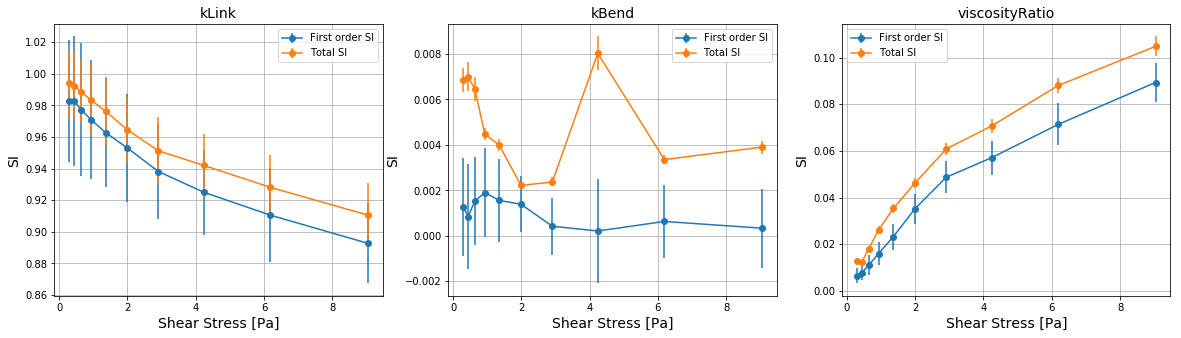

In [9]:
plt.figure(figsize=(20,5))
plt.title("Sobol indices",fontsize=14)
for n in range(len(model_params)):
    plt.subplot(1,3,n+1)
    plt.title(names[model_params[n]],fontsize=14)
    plt.grid(True)
    plt.xlabel("Shear Stress [Pa]",fontsize=14)
    plt.ylabel("SI",fontsize=14)
    
    plt.errorbar(stress,S1[n],yerr=S1_conf[n],fmt="o-",label="First order SI")
    plt.errorbar(stress,ST[n],yerr=ST_conf[n],fmt="o-",label="Total SI")
    
    plt.legend()

plt.show()

## Setup TMCMC sampling

In [7]:
def evaluate_GP(params):
    kLink = params["kLink"]
    kBend = params["kBend"]
    viscosityRatio = params["viscosityRatio"]
    shearrate = params["shearrate"]
    
    arr = np.array([kLink,kBend,viscosityRatio,shearrate])[None,:]
    mean,std = predictionModel.predict(arr,return_std=True)
    return mean[0],std[0]

def model_prior(sample,enableInteriorViscosity):
    kLink_prior = uniform.pdf(sample[0],10.0,290.0)
    kBend_prior = uniform.pdf(sample[1],50.0,350.0)
    
    if enableInteriorViscosity:
        viscosityRatio_prior = uniform.pdf(sample[2],1.0,14.0)
        return np.prod([kLink_prior,kBend_prior,viscosityRatio_prior])
    else:
        return np.prod([kLink_prior,kBend_prior])

def model_sampler(n_samples,enableInteriorViscosity):
    kLink_samples = np.random.uniform(10.0,300.0,n_samples)
    kBend_samples = np.random.uniform(50.0,400.0,n_samples)
    
    if enableInteriorViscosity:
        viscosityRatio_samples = np.random.uniform(1.0,15.0,n_samples)
        return np.column_stack([kLink_samples,kBend_samples,viscosityRatio_samples])
    else:
        return np.column_stack([kLink_samples,kBend_samples])

def model_prior_gaussian(sample,enableInteriorViscosity):
    a,b,mean,std = 10,300,40,20
    kLink_prior = truncnorm.pdf(sample[0],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
    
    a,b,mean,std = 50,400,320,100
    kBend_prior = truncnorm.pdf(sample[1],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
    
    if enableInteriorViscosity:
        a,b,mean,std = 1,15,5,3
        viscosityRatio_prior = truncnorm.pdf(sample[2],(a-mean)/std,(b-mean)/std,loc=mean,scale=std)
        return np.prod([kLink_prior,kBend_prior,viscosityRatio_prior])
    else:
        return np.prod([kLink_prior,kBend_prior])

def model_sampler_gaussian(n_samples,enableInteriorViscosity):
    a,b,mean,std = 10,300,40,20
    kLink_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=n_samples)
    
    a,b,mean,std = 50,400,320,100
    kBend_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=n_samples)
    
    if enableInteriorViscosity:
        a,b,mean,std = 1,15,5,3
        viscosityRatio_samples = truncnorm.rvs((a-mean)/std,(b-mean)/std,loc=mean,scale=std,size=n_samples)
        return np.column_stack([kLink_samples,kBend_samples,viscosityRatio_samples])
    else:
        return np.column_stack([kLink_samples,kBend_samples])
    
def error_prior(sample):
    return np.prod(uniform.pdf(sample,0.001,0.099))

def error_sampler(n_samples):
    return np.random.uniform(0.001,0.1,(n_samples,1))

## Sanity Check

### Healthy

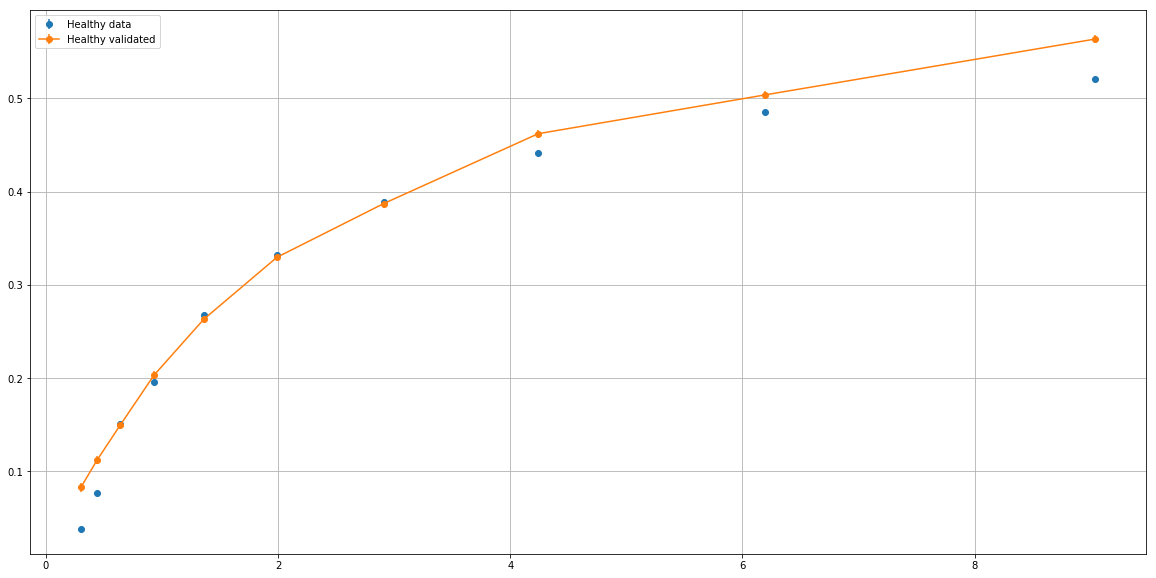

In [8]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el = data.values[imin:imax,[1,2]].T

el_err = np.zeros(stress.shape)

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

healthy_samples = np.zeros((shearrate.shape[0],x_train.shape[1]))

healthy_samples[:,:-1] = np.array([40,250,5])
healthy_samples[:,-1] = shearrate

healthy_qoi,healthy_std = predictionModel.predict(healthy_samples,return_std=True)

plt.figure(figsize=(20,10))

plt.errorbar(stress,el,yerr=el_err,fmt='o',label="Healthy data")
plt.errorbar(stress,healthy_qoi,yerr=healthy_std,fmt='o-',label="Healthy validated")

plt.grid(True)
plt.legend()

plt.show()

### Treated

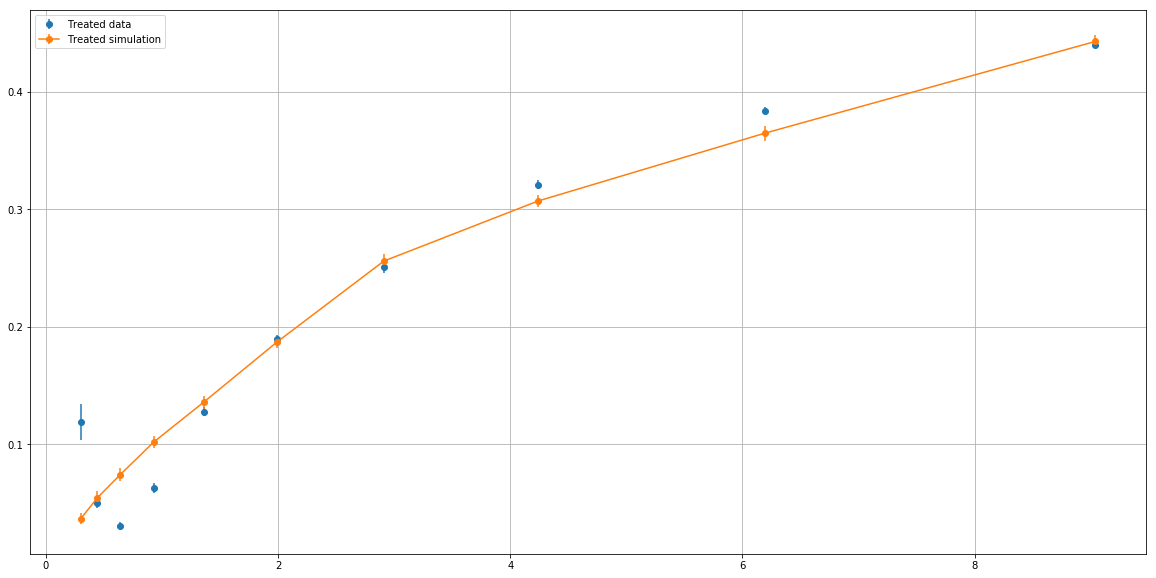

In [9]:
imin = 0
imax = 10

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]
stress,el,el_err = data.values[imin:imax,[1,3,4]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

shearrate = stress / (nuP * rhoP)

treated_samples = np.zeros((shearrate.shape[0],x_train.shape[1]))

treated_samples[:,:-1] = np.array([110,395,3.5])
treated_samples[:,-1] = shearrate

treated_qoi,treated_std = predictionModel.predict(treated_samples,return_std=True)

plt.figure(figsize=(20,10))

plt.errorbar(stress,el,yerr=el_err,fmt='o',label="Treated data")
plt.errorbar(stress,treated_qoi,yerr=treated_std,fmt='o-',label="Treated simulation")

plt.grid(True)
plt.legend()

plt.show()

## TMCMC sampling

In [24]:
cellHealth = "healthy"

imin=2
imax=8

# Load data for comparison with results
data = pd.read_csv("%s/Ekcta_100.csv" % (datapath),sep=";")
data = data.loc[data["Treatment"] == 0.5]

if cellHealth == "healthy":
    stress,el = data.values[imin:imax,[1,2]].T
    el_err = np.zeros(stress.shape)
elif cellHealth == "treated":
    stress,el,el_err = data.values[imin:imax,[1,3,4]].T

# Get data from config files
configpath = "%s/hemocell/templates/config_template.xml" % (libpath)
tree = etree.parse(configpath, parser=etree.XMLParser(remove_blank_text=True, remove_comments=True))
root = tree.getroot()
nuP = float(root.find("domain/nuP").text)
rhoP = float(root.find("domain/rhoP").text)

print(data)

    Treatment  Stress (pa)  EL Healthy  EL 100%  EL error (+/-)
45        0.5         0.30       0.038    0.119           0.015
46        0.5         0.44       0.077    0.050           0.004
47        0.5         0.64       0.151    0.031           0.003
48        0.5         0.93       0.196    0.063           0.004
49        0.5         1.36       0.268    0.128           0.004
50        0.5         1.99       0.332    0.190           0.003
51        0.5         2.91       0.389    0.251           0.005
52        0.5         4.24       0.441    0.321           0.004
53        0.5         6.19       0.485    0.384           0.003
54        0.5         9.04       0.521    0.440           0.003
55        0.5        13.20       0.549    0.487           0.002
56        0.5        19.28       0.576    0.523           0.004
57        0.5        28.15       0.598    0.554           0.002
58        0.5        41.10       0.620    0.581           0.002
59        0.5        60.00       0.639  

In [11]:
np.random.seed(7773777)

n_samples = 10000

model_params = ["kLink","kBend","viscosityRatio"]
error_params = ["err"]
design_vars = ["shearrate"]

# Full parameter set
params = model_params + error_params

# Compute the shear rates
shearrate = stress / (nuP * rhoP)

# Map model errors to data samples
error_mapping = ["err" for n in range(shearrate.shape[0])]

# Construct problem dict
problem = {"model_type":"python",
           "evaluate":evaluate_GP,
           "model_params":model_params,
           "error_params":error_params,
           "design_vars":design_vars,
           "input_data":shearrate,
           "output_data":el,
           "data_errors":el_err,
           "error_mapping":error_mapping,
           "model_prior":(lambda sample: model_prior(sample,1)),
           "model_sampler":(lambda n_samples: model_sampler(n_samples,1)),
           "error_prior":error_prior,
           "error_sampler":error_sampler
          }

TMCMC_sampler = TMCMC.TMCMC(problem,lmax=1,logpath=None,logstep=1e6)
df,qoi,c_err = TMCMC_sampler.sample(n_samples)

print(df)

Initializing...


100%|██████████| 1000/1000 [03:15<00:00,  4.70it/s]


Current max likelihood: 1459901464.641495
Calculating p for stage 1...
p: 0.004526044865726837
COV: 1.0000000040006116
Running stage 1...
Maximum chain length: 1


100%|██████████| 1000/1000 [02:48<00:00,  5.27it/s]


Current max likelihood: 556415534.0634632
Calculating p for stage 2...
p: 0.021207002957951904
COV: 1.0000000004860474
Running stage 2...
Maximum chain length: 1


100%|██████████| 1000/1000 [03:02<00:00,  5.58it/s]


Current max likelihood: 10764446741.929274
Calculating p for stage 3...
p: 0.0944275301467007
COV: 0.9999999972676632
Running stage 3...
Maximum chain length: 1


100%|██████████| 1000/1000 [02:59<00:00,  5.45it/s]


Current max likelihood: 10764446741.929274
Calculating p for stage 4...
p: 0.3424326715946216
COV: 1.0000000022545552
Running stage 4...
Maximum chain length: 1


100%|██████████| 1000/1000 [02:58<00:00,  6.07it/s]


Current max likelihood: 13360724745.277388
Calculating p for stage 5...
p: 0.6671342690442182
COV: 1.000000001115379
Running stage 5...
Maximum chain length: 1


100%|██████████| 1000/1000 [03:05<00:00,  5.60it/s]


Current max likelihood: 17584805729.972385
Calculating p for stage 6...
p: 1.0
COV: 0.7849016977292594
Running stage 6...
Maximum chain length: 1


100%|██████████| 1000/1000 [03:02<00:00,  5.98it/s]


Current max likelihood: 17584805729.972385
Sampling finished :)
         kLink       kBend  viscosityRatio       err    likelihood     prior
0    40.909304  205.151737        4.873358  0.017947  1.076445e+10  0.000007
1    40.217287  205.139323        6.861035  0.051115  1.932675e+07  0.000007
2    39.801193  373.110569        4.984608  0.039519  2.155444e+08  0.000007
3    40.909304  205.151737        4.873358  0.017947  1.076445e+10  0.000007
4    41.959590  200.479535        4.794071  0.017456  8.070395e+09  0.000007
5    40.374258  187.666498        5.441488  0.038338  6.006228e+08  0.000007
6    40.909304  205.151737        4.873358  0.017947  1.076445e+10  0.000007
7    43.151743  151.170553        4.816736  0.040785  5.825202e+08  0.000007
8    42.909401  199.399498        3.953609  0.018197  4.647390e+09  0.000007
9    42.483172  299.394318        4.116590  0.057862  1.308883e+08  0.000007
10   39.838234  321.997074        4.554355  0.030677  2.578544e+09  0.000007
11   43.0425

## Analyze results

In [12]:
method = "TMCMC"

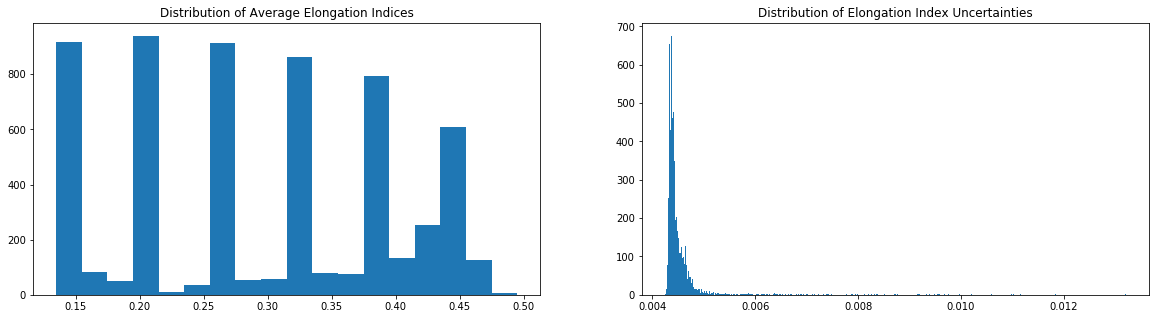

In [26]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title("Distribution of Average Elongation Indices")
plt.hist(qoi.flatten(),bins='auto')

plt.subplot(1,2,2)
plt.title("Distribution of Elongation Index Uncertainties")
plt.hist(c_err.flatten(),bins='auto')
plt.show()

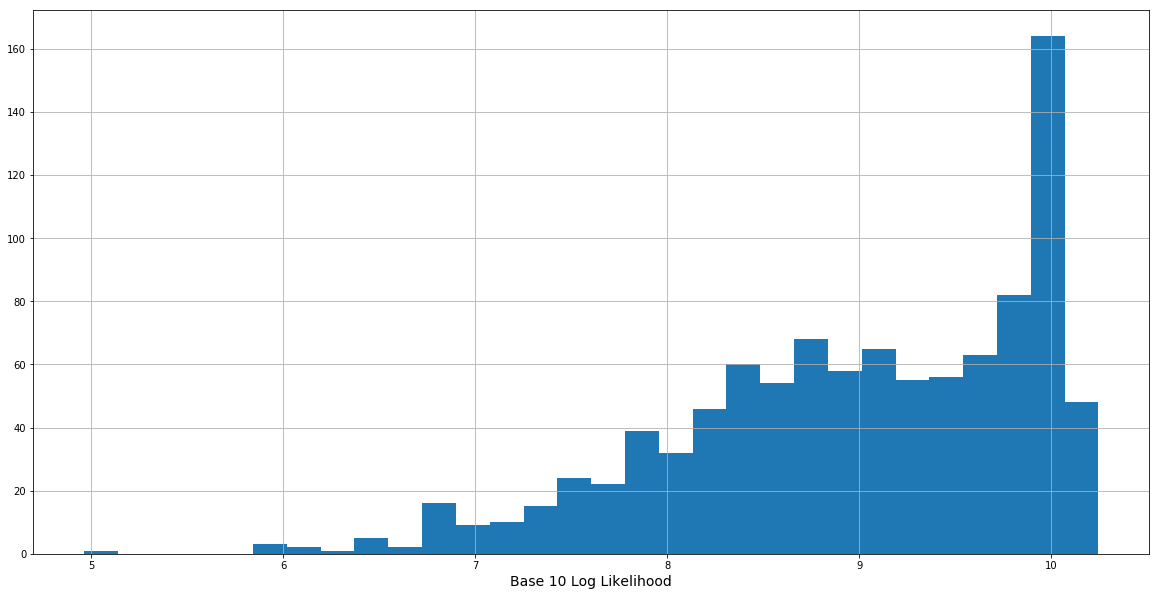

In [13]:
nbins = 30
plt.figure(figsize=(20,10))
plt.grid(True)

if method == "TMCMC":
    plt.xlabel(r"Base 10 Log Likelihood",fontsize=14)
    plt.hist(np.log10(df["likelihood"].values),bins=nbins)
    
plt.show()

In [14]:
if method == "TMCMC":
    for n in range(-10,16):
        print("Number of high densities larger than %e:" % (10**n),np.sum(df["likelihood"].values > 10**n))

Number of high densities larger than 1.000000e-10: 1000
Number of high densities larger than 1.000000e-09: 1000
Number of high densities larger than 1.000000e-08: 1000
Number of high densities larger than 1.000000e-07: 1000
Number of high densities larger than 1.000000e-06: 1000
Number of high densities larger than 1.000000e-05: 1000
Number of high densities larger than 1.000000e-04: 1000
Number of high densities larger than 1.000000e-03: 1000
Number of high densities larger than 1.000000e-02: 1000
Number of high densities larger than 1.000000e-01: 1000
Number of high densities larger than 1.000000e+00: 1000
Number of high densities larger than 1.000000e+01: 1000
Number of high densities larger than 1.000000e+02: 1000
Number of high densities larger than 1.000000e+03: 1000
Number of high densities larger than 1.000000e+04: 1000
Number of high densities larger than 1.000000e+05: 999
Number of high densities larger than 1.000000e+06: 997
Number of high densities larger than 1.000000e+07:

Best sample:
kLink             4.732023e+01
kBend             1.483727e+02
viscosityRatio    3.130317e+00
err               1.744623e-02
likelihood        1.758481e+10
prior             7.108381e-06
Name: 780, dtype: float64


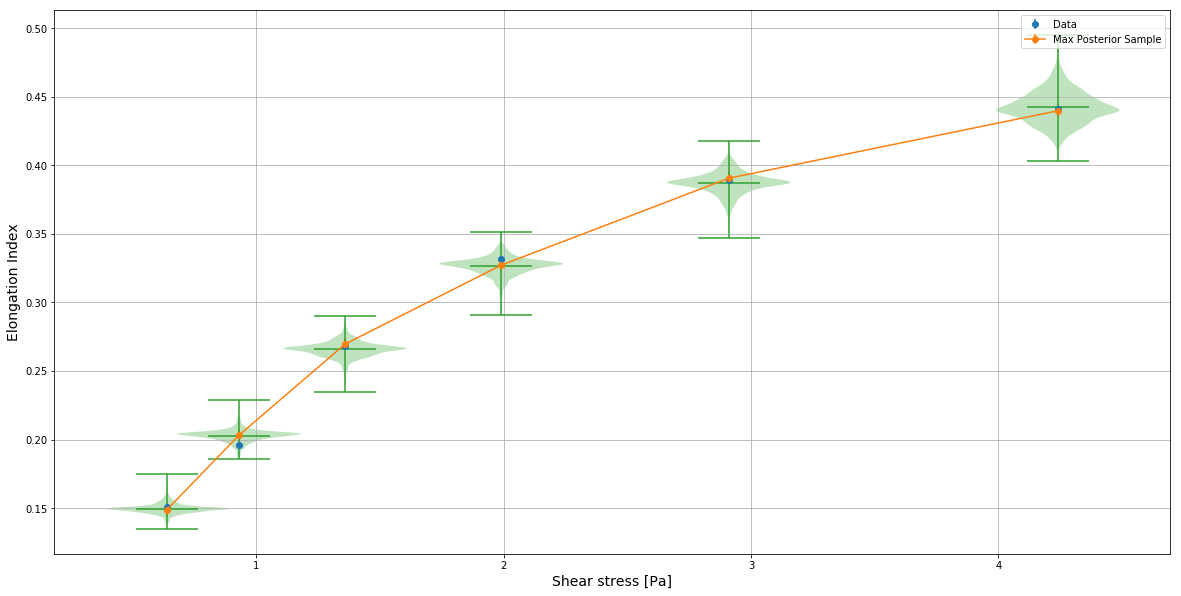

In [15]:
plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")

# Highest likelihood
if method == "TMCMC":
    mle = np.argmax(df["likelihood"].values)
    mpe = np.argmax(df["likelihood"].values * df["prior"].values)
    #print("Max likelihood:",sample_df["likelihood"].values[mle])
elif method == "ABCSubSim":
    mle = np.argmin(df["distance"].values)
    #print("Minimum distance:",sample_df["distance"].values[mle])

print("Best sample:")
print(df.loc[mpe])
    
#plt.errorbar(stress,qoi[mle],c_err[mle],fmt="o-",label="Max Likelihood Sample")
plt.errorbar(stress,qoi[mpe],c_err[mpe],fmt="o-",label="Max Posterior Sample")

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

ptile = np.percentile(qoi,[2.5,97.5],axis=0)

ptile[0] = mean - ptile[0]
ptile[1] -= mean

#plt.errorbar(stress,mean,yerr=ptile,fmt="o-",label="Mean QoI")

plt.violinplot(qoi,stress,showmeans=True)

plt.legend()
plt.show()

In [16]:
"""
plt.figure(figsize=(20,10))
plt.xlabel("Shear stress [Pa]",fontsize=14)
plt.ylabel("Elongation Index",fontsize=14)

plt.grid(True)

# Plot all qoi
for n in range(qoi.shape[0]):
    plt.plot(stress,qoi[n])

# Data
plt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")
    
plt.legend()

plt.show()
"""

'\nplt.figure(figsize=(20,10))\nplt.xlabel("Shear stress [Pa]",fontsize=14)\nplt.ylabel("Elongation Index",fontsize=14)\n\nplt.grid(True)\n\n# Plot all qoi\nfor n in range(qoi.shape[0]):\n    plt.plot(stress,qoi[n])\n\n# Data\nplt.errorbar(stress,el,yerr=el_err,fmt="o",label="Data")\n    \nplt.legend()\n\nplt.show()\n'

## Parameter distributions in 1D

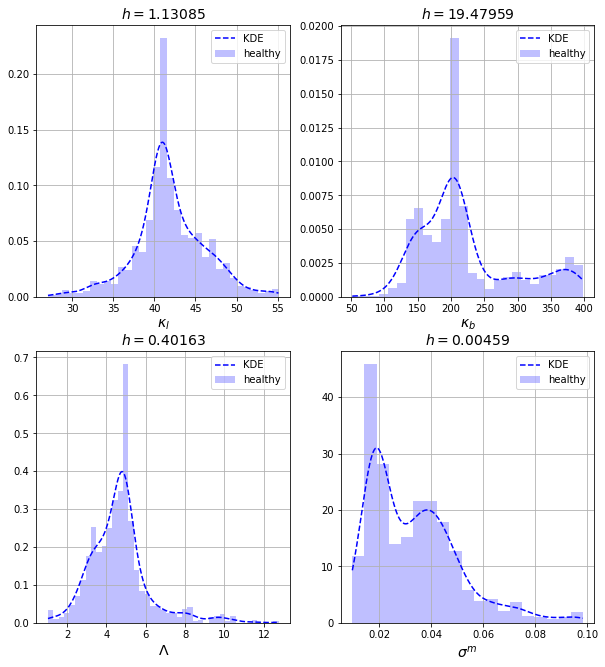

In [32]:
color = "b"

plt.figure(figsize=(10,11))
for n in range(len(params)):
    vals = df[params[n]].values
    
    kde = sm.nonparametric.KDEMultivariate(data=vals,var_type="c",bw="normal_reference")
    
    x_vals = np.linspace(np.min(vals),np.max(vals),1000)
    y_vals = kde.pdf(x_vals)
    
    plt.subplot(2,2,n+1)
    plt.title(r"$h = %.5f$" % kde.bw,fontsize=14)
    plt.grid(True)
    plt.xlabel(names[params[n]],fontsize=14)
    plt.hist(df[params[n]].values,color=color,bins="auto",density=True,alpha=0.25,label=cellHealth)
    plt.plot(x_vals,y_vals,color+'--',label="KDE")
    plt.legend()
    
plt.show()

## Plot parameters in 2D

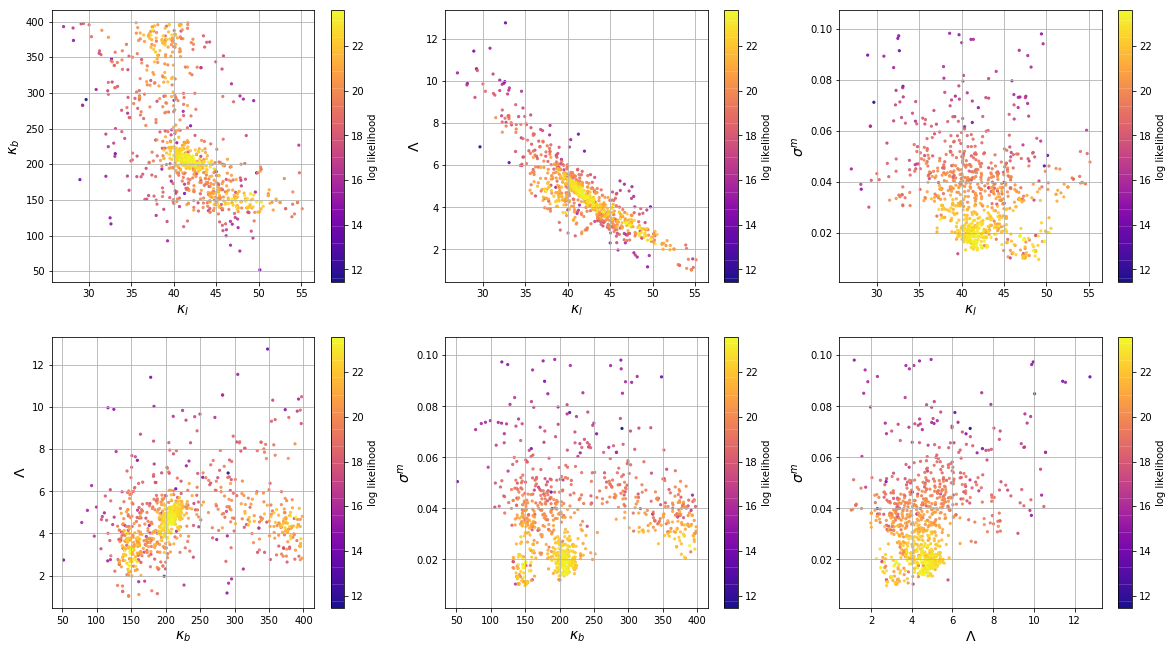

In [22]:
plt.figure(figsize=(20,11))

count = 1
s=5
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            plt.subplot(2,3,count)
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=14)
            plt.ylabel(names[params[m]],fontsize=14)
            if method == "TMCMC":
                order = np.argsort(df["likelihood"])
                plt.scatter(df[params[n]].values[order],df[params[m]].values[order],
                            s=s,c=np.log(df["likelihood"].values[order]),cmap="plasma",alpha=0.8)
                
            elif method == "ABCSubSim":
                order = np.argsort(df["distance"])[::-1]
                plt.scatter(df[params[n]].values[order],df[params[m]].values[order],
                            s=s,c=df["distance"].values[order],cmap="inferno")
                
            plt.colorbar(label="log likelihood")
            count += 1

plt.show()

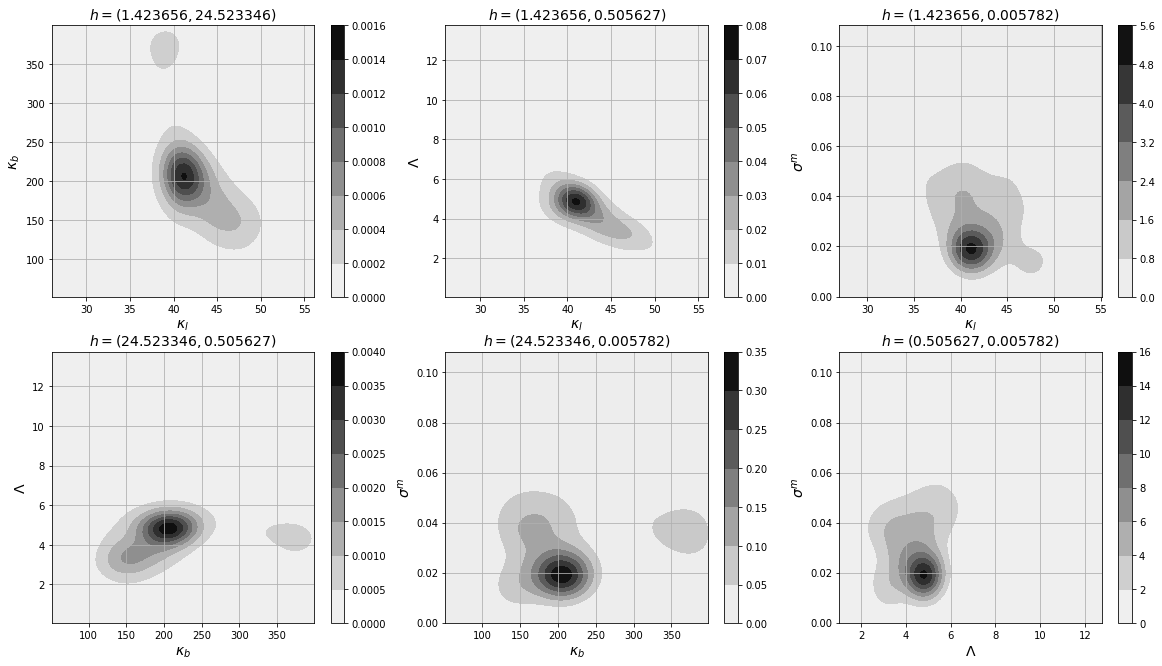

In [19]:
plt.figure(figsize=(20,11))

zoom = [1.0,1.0,0.01,
        1.0,0.01,0.01]

count = 1
for n in range(len(params)):
    for m in range(n,len(params)):
        if n != m:
            vals = df[[params[n],params[m]]].values
            
            kde = sm.nonparametric.KDEMultivariate(data=vals,var_type="cc",bw="normal_reference")
            
            x = np.linspace(np.min(vals[:,0])-zoom[count-1],np.max(vals[:,0])+zoom[count-1],100)
            y = np.linspace(np.min(vals[:,1])-zoom[count-1],np.max(vals[:,1])+zoom[count-1],100)
            xx,yy = np.meshgrid(x,y)
            
            grid_flat = np.column_stack([xx.flatten(),yy.flatten()])
            grid_vals = kde.pdf(grid_flat).reshape(xx.shape)
            
            plt.subplot(2,3,count)
            plt.title(r"$h = (%f,%f)$" % tuple(kde.bw),fontsize=14)
            plt.grid(True)
            plt.xlabel(names[params[n]],fontsize=14)
            plt.ylabel(names[params[m]],fontsize=14)
            plt.contourf(xx,yy,grid_vals,cmap="gray_r")
            plt.colorbar()
            count += 1

plt.show()